In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#!pip install PyWavelets --no-deps

In [3]:
from typing import Tuple, Union, Optional, List
import os
import numpy as np
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, AdamW
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

T  = torch.Tensor
TN = Optional[T]
TS = Union[Tuple[T, ...], List[T]]

device = torch.device('cuda:0')

## Delta Denoising Score: zero-shot image editing

In [4]:
def load_512(image_path: str, left=0, right=0, top=0, bottom=0):
    image = np.array(Image.open(image_path))[:, :, :3]    
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image


@torch.no_grad()
def get_text_embeddings(pipe: StableDiffusionPipeline, text: str) -> T:
    tokens = pipe.tokenizer([text], padding="max_length", max_length=77, truncation=True,
                                   return_tensors="pt", return_overflowing_tokens=True).input_ids.to(device)
    return pipe.text_encoder(tokens).last_hidden_state.detach()

@torch.no_grad()
def denormalize(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image[0]


@torch.no_grad()
def decode(latent: T, pipe: StableDiffusionPipeline, im_cat: TN = None):
    image = pipeline.vae.decode((1 / 0.18215) * latent, return_dict=False)[0]
    image = denormalize(image)
    if im_cat is not None:
        image = np.concatenate((im_cat, image), axis=1)
    return Image.fromarray(image)


In [5]:

def init_pipe(device, dtype, unet, scheduler) -> Tuple[UNet2DConditionModel, T, T]:

    with torch.inference_mode():
        alphas = torch.sqrt(scheduler.alphas_cumprod).to(device, dtype=dtype)
        sigmas = torch.sqrt(1 - scheduler.alphas_cumprod).to(device, dtype=dtype)
    for p in unet.parameters():
        p.requires_grad = False
    return unet, alphas, sigmas


class DDSLoss:

    def noise_input(self, z, eps=None, timestep: Optional[int] = None):
        if timestep is None:
            b = z.shape[0]
            timestep = torch.randint(
                low=self.t_min,
                high=min(self.t_max, 1000) - 1,  # Avoid the highest timestep.
                size=(b,),
                device=z.device, dtype=torch.long)
        if eps is None:
            eps = torch.randn_like(z)
        alpha_t = self.alphas[timestep, None, None, None]
        sigma_t = self.sigmas[timestep, None, None, None]
        z_t = alpha_t * z + sigma_t * eps
        return z_t, eps, timestep, alpha_t, sigma_t

    def get_eps_prediction(self, z_t: T, timestep: T, text_embeddings: T, alpha_t: T, sigma_t: T, get_raw=False,
                           guidance_scale=7.5):

        latent_input = torch.cat([z_t] * 2)
        timestep = torch.cat([timestep] * 2)
        embedd = text_embeddings.permute(1, 0, 2, 3).reshape(-1, *text_embeddings.shape[2:])
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            e_t = self.unet(latent_input, timestep, embedd).sample
            if self.prediction_type == 'v_prediction':
                e_t = torch.cat([alpha_t] * 2) * e_t + torch.cat([sigma_t] * 2) * latent_input
            e_t_uncond, e_t = e_t.chunk(2)
            if get_raw:
                return e_t_uncond, e_t
            e_t = e_t_uncond + guidance_scale * (e_t - e_t_uncond)
            assert torch.isfinite(e_t).all()
        if get_raw:
            return e_t
        pred_z0 = (z_t - sigma_t * e_t) / alpha_t
        return e_t, pred_z0

    def get_sds_loss(self, z: T, text_embeddings: T, eps: TN = None, mask=None, t=None,
                 timestep: Optional[int] = None, guidance_scale=7.5) -> TS:
        with torch.inference_mode():
            z_t, eps, timestep, alpha_t, sigma_t = self.noise_input(z, eps=eps, timestep=timestep)
            e_t, _ = self.get_eps_prediction(z_t, timestep, text_embeddings, alpha_t, sigma_t,
                                             guidance_scale=guidance_scale)
            grad_z = (alpha_t ** self.alpha_exp) * (sigma_t ** self.sigma_exp) * (e_t - eps)
            assert torch.isfinite(grad_z).all()
            grad_z = torch.nan_to_num(grad_z.detach(), 0.0, 0.0, 0.0)
            if mask is not None:
                grad_z = grad_z * mask
            log_loss = (grad_z ** 2).mean()
        sds_loss = grad_z.clone() * z
        del grad_z
        return sds_loss.sum() / (z.shape[2] * z.shape[3]), log_loss


    def get_dds_loss(self, z_source: T, z_target: T, text_emb_source: T, text_emb_target: T,
                            eps=None, reduction='mean', symmetric: bool = False, calibration_grad=None, timestep: Optional[int] = None,
                      guidance_scale=7.5, raw_log=False) -> TS:
        with torch.inference_mode():
            z_t_source, eps, timestep, alpha_t, sigma_t = self.noise_input(z_source, eps, timestep)
            z_t_target, _, _, _, _ = self.noise_input(z_target, eps, timestep)
            eps_pred, _ = self.get_eps_prediction(torch.cat((z_t_source, z_t_target)),
                                                  torch.cat((timestep, timestep)),
                                                  torch.cat((text_emb_source, text_emb_target)),
                                                  torch.cat((alpha_t, alpha_t)),
                                                  torch.cat((sigma_t, sigma_t)),
                                                  guidance_scale=guidance_scale)
            eps_pred_source, eps_pred_target = eps_pred.chunk(2)
            grad = (alpha_t ** self.alpha_exp) * (sigma_t ** self.sigma_exp) * (eps_pred_target - eps_pred_source)
            if calibration_grad is not None:
                if calibration_grad.dim() == 4:
                    grad = grad - calibration_grad
                else:
                    grad = grad - calibration_grad[timestep - self.t_min]
            if raw_log:
                log_loss = eps.detach().cpu(), eps_pred_target.detach().cpu(), eps_pred_source.detach().cpu()
            else:
                log_loss = (grad ** 2).mean()
        loss = z_target * grad.clone()
        if symmetric:
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
            loss_symm = self.rescale * z_source * (-grad.clone())
            loss += loss_symm.sum() / (z_target.shape[2] * z_target.shape[3])
        elif reduction == 'mean':
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
        return loss, log_loss

    def __init__(self, device, pipe: StableDiffusionPipeline, dtype=torch.float32):
        self.t_min = 50
        self.t_max = 950
        self.alpha_exp = 0
        self.sigma_exp = 0
        self.dtype = dtype
        self.unet, self.alphas, self.sigmas = init_pipe(device, dtype, pipe.unet, pipe.scheduler)
        self.prediction_type = pipe.scheduler.prediction_type

In [6]:
model_id  =  ["runwayml/stable-diffusion-v1-5", "stabilityai/stable-diffusion-2-1"][0]
pipeline = StableDiffusionPipeline.from_pretrained(model_id,).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [7]:
def low_pass_filter_grad_wavelet_torch(
    grad: torch.Tensor,
    wavelet: str = "haar",
    mode: str = "periodization",
    level: int = 1
) -> torch.Tensor:
    """
    Applies a true wavelet low‑pass filter to a gradient tensor by
    zeroing out all detail coefficients above the given level.

    Args:
        grad (torch.Tensor): [B, C, H, W] gradient tensor.
        wavelet (str): name of the wavelet to use (e.g. 'haar', 'db8', 'sym3', ...).
        mode (str): signal extension mode for PyWavelets (default 'periodization').
        level (int): decomposition level; higher == coarser low‑freq pass.

    Returns:
        torch.Tensor: low‑frequency filtered gradient, same shape/device as input.
    """
    device = grad.device
    grad_np = grad.detach().cpu().numpy()
    B, C, H, W = grad_np.shape
    out_np = np.zeros_like(grad_np)

    for b in range(B):
        for c in range(C):
            # 2D wavelet decomposition
            coeffs = pywt.wavedec2(grad_np[b, c], wavelet=wavelet, mode=mode, level=level)
            # coeffs = [cA, (cH1, cV1, cD1), (cH2, cV2, cD2), ...]
            cA, *details = coeffs

            # Zero‐out all detail bands
            filtered = [cA] + [
                tuple(np.zeros_like(arr) for arr in detail_band)
                for detail_band in details
            ]

            # Reconstruct only from the approximation coefficients
            rec = pywt.waverec2(filtered, wavelet=wavelet, mode=mode)

            # pywt may give back a slightly larger shape—crop to original
            rec = rec[:H, :W]
            out_np[b, c] = rec

    return torch.from_numpy(out_np).to(device)


def image_optimization(
    pipe: StableDiffusionPipeline,
    image: np.ndarray,
    text_source: str,
    text_target: str,
    num_iters: int = 200,
    use_dds: bool = True,
    wavelet: str = "haar",
    level: int = 1,
) -> np.ndarray:
    """
    Optimize an input image via DDS or SDS loss, with optional wavelet low-pass filtering
    on the gradient.

    Args:
        pipe: instantiated StableDiffusionPipeline (with VAE & UNet).
        image: H×W×3 uint8 array in [0,255].
        text_source: prompt describing the original image.
        text_target: prompt describing desired edit.
        num_iters: number of optimization steps.
        use_dds: if True, use DDSLoss; otherwise use SDSLoss.
        wavelet: name of the PyWavelets wavelet (e.g. 'db8', 'sym5', ...).
        level: decomposition level for low-pass filtering.

    Returns:
        Edited image as a H×W×3 uint8 NumPy array.
    """
    # Initialize the appropriate loss
    loss_fn = DDSLoss(device, pipe) if use_dds else SDSLoss(device, pipe)

    # Preprocess image → latent
    img_t = torch.from_numpy(image).float().permute(2,0,1) / 127.5 - 1.0
    img_t = img_t.unsqueeze(0).to(device)
    with torch.no_grad():
        z_src = pipe.vae.encode(img_t)["latent_dist"].mean * 0.18215

        # Prepare text embeddings
        emb_null   = get_text_embeddings(pipe, "")
        emb_src    = get_text_embeddings(pipe, text_source)
        emb_tgt    = get_text_embeddings(pipe, text_target)
        emb_source = torch.stack([emb_null, emb_src], dim=1)
        emb_target = torch.stack([emb_null, emb_tgt], dim=1)

    # Set up optimization on a copy of z_src
    z_tgt = z_src.clone().detach().requires_grad_(True)
    optimizer = SGD([z_tgt], lr=1e-1)

    for i in range(1, num_iters+1):
        # Compute loss & backward
        if use_dds:
            loss, _log = loss_fn.get_dds_loss(z_src, z_tgt, emb_source, emb_target)
        else:
            loss, _log = loss_fn.get_sds_loss(z_tgt, emb_target)

        optimizer.zero_grad()
        (2000 * loss).backward()

        # Wavelet low-pass filter on gradient
        with torch.no_grad():
            filtered = low_pass_filter_grad_wavelet_torch(
                z_tgt.grad,
                wavelet=wavelet,
                level=level
            )
            z_tgt.grad.copy_(filtered)

        optimizer.step()

        # Optional periodic display
        if i % 100 == 0:
            print(f"Iteration {i}/{num_iters} — loss {loss.item():.4f}")
            out_img = decode(z_tgt, pipe)
            clear_output(wait=True)
            display(out_img)

    # Final decode and return as NumPy
    final = decode(z_tgt, pipe)
    return np.array(final)

### DDS image optimization

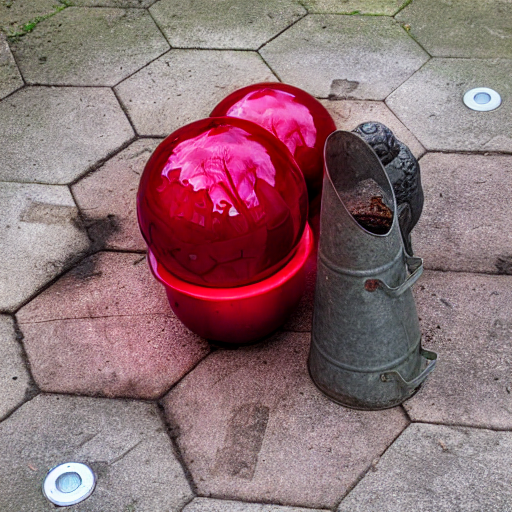

In [8]:
path = "data/image_1.jpg"
image = load_512(path)

out_lf = image_optimization(
    pipe=pipeline,
    image=image,
    text_source= (
        "a photo of two reflective spheres."
    ),
    text_target=(
        "a photo of two reflective red spheres."
    ),
    num_iters=300,
    use_dds=True,
    wavelet="db8",
    level=1
)

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

image_name = "image_1"
out_dir = f"comparison/{image_name}"
os.makedirs(out_dir, exist_ok=True)

# If out_lf is in [−1,1] float or [0,1] float, convert to uint8:
if out_lf.dtype != np.uint8:
    # Example normalization from (−1…1) to (0…255)
    img_uint8 = ((out_lf + 1) * 127.5).clip(0, 255).astype(np.uint8)
else:
    img_uint8 = out_lf

# Correct order: filename first, array second
plt.imsave(f"{out_dir}/efe.png", img_uint8)